# Snake

In [1]:
import environments_fully_observable 
import environments_partially_observable
import numpy as np
from  tqdm import trange
import matplotlib.pyplot as plt
import random
import tensorflow as tf
tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)

2024-03-18 10:27:34.107754: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-18 10:27:34.135458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 10:27:34.135515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 10:27:34.136390: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-18 10:27:34.142149: I tensorflow/core/platform/cpu_feature_guar

## Environment definition

In [2]:
%matplotlib inline
# function to standardize getting an env for the whole notebook
def get_env(n=1000):
    # n is the number of boards that you want to simulate parallely
    # size is the size of each board, also considering the borders
    # mask for the partially observable, is the size of the local neighborhood
    size = 7
    e = environments_fully_observable.OriginalSnakeEnvironment(n, size)
    #e = environments_partially_observable.OriginalSnakeEnvironment(n, size, 2)
    return e
    
GAMMA = .99
ITERATIONS = 5000

# Model

Here is defined the architecture of the Agent considering the fact that Double Deep-Q-Networks algorithm will be implemented

In [3]:
class Agent:
    def __init__(self, env: environments_fully_observable.BaseEnvironment, discount=GAMMA, step_size=1e-3):
        self.discount = discount
        self.network = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, kernel_initializer = tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation(tf.nn.relu),
            tf.keras.layers.Dense(128, kernel_initializer = tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation(tf.nn.relu),
            tf.keras.layers.Dense(4, activation='linear', kernel_initializer = tf.keras.initializers.HeNormal())
        ])       
        self.target_network = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, kernel_initializer = tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation(tf.nn.relu),
            tf.keras.layers.Dense(128, kernel_initializer = tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation(tf.nn.relu),
            tf.keras.layers.Dense(4, activation='linear', kernel_initializer = tf.keras.initializers.HeNormal())
        ])
        self.optimizer_net = tf.keras.optimizers.Adam(step_size)

# Training
Training procedure for the Agent. The training is carried out over 50000 iterations.

In [4]:
# Define variables for training
train_env = get_env(100)
train_agent = Agent(train_env.boards)
train_total_rewards, train_fruits_eaten, train_wall_hits, train_body_hits = [], [], [], []
epsilon = 1.0
min_epsilon = 0.1
decay_rate = 0.99
mse = tf.keras.losses.MeanSquaredError() 

for iteration in trange(50000):
    if iteration % 150 == 0 and epsilon > min_epsilon: 
        epsilon = epsilon * decay_rate
    if iteration % 1000 == 0:
        print(f"{iteration}/{50000} - {np.mean(train_total_rewards[-30:]) or 0}", end="\n")
    
    # Get current state of the board 
    states = train_env.to_state()
    
    with tf.GradientTape(persistent=True) as tape:

        # Compute the q-values for the current state
        q_values = train_agent.network(states)
        
        # Sample action using an epsilon-greedy policy based on Q
        if np.random.rand() < epsilon:
            train_actions = tf.random.categorical(q_values, 1)
        else: 
            train_actions = tf.expand_dims(tf.argmax(q_values, axis=1), axis=1)
        
        # Observe rewards
        train_rewards = train_env.move(train_actions)

        # Collect some data
        train_fruits_eaten.append(tf.math.count_nonzero(tf.reshape(train_rewards, -1) == 0.5).numpy())
        train_wall_hits.append(tf.math.count_nonzero(tf.reshape(train_rewards, -1) == -0.1).numpy())
        train_body_hits.append(tf.math.count_nonzero(tf.reshape(train_rewards, -1) == -0.2).numpy())
        train_total_rewards.append(np.mean(train_rewards))
        
        # Observe new states
        new_states = train_env.to_state()
        
        # Start learning
        one_hot_actions = tf.reshape(tf.one_hot(train_actions, 4), (len(train_env.boards), 4))
        action_net = train_agent.network(states)
        actions_q_value = tf.reduce_sum(one_hot_actions * action_net, axis=-1, keepdims=True)
        q_target = train_agent.target_network(new_states)

        # Compute loss of iteration
        y_i = train_rewards  + train_agent.discount * tf.expand_dims(tf.reduce_max(q_target, axis=1), axis=1)
        loss = mse(y_i, actions_q_value)
        
    # Update weights of the network
    gradient = tape.gradient(loss, train_agent.network.trainable_weights)
    train_agent.optimizer_net.apply_gradients(zip(gradient, train_agent.network.trainable_weights))           

    # Every 2000 iterations update the weights of the target network
    if iteration % 2000 == 0:
        train_agent.target_network.set_weights(train_agent.network.get_weights())         

2024-03-18 10:27:36.188773: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-18 10:27:36.214334: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-18 10:27:36.214369: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-18 10:27:36.217390: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-18 10:27:36.217420: I external/local_xla/xla/stream_executor

0/50000 - nan


2024-03-18 10:27:37.118416: I external/local_xla/xla/service/service.cc:168] XLA service 0x55b809f80940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-18 10:27:37.118491: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX450, Compute Capability 7.5
2024-03-18 10:27:37.122646: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-18 10:27:37.136379: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1710754057.200767   34488 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  2%|██▏                                                                                                         | 1004/50000 [00:31<24:14, 33.69it/s]

1000/50000 - -0.011033332906663418


  4%|████▎                                                                                                       | 2003/50000 [01:05<28:23, 28.18it/s]

2000/50000 - -0.006366667337715626


  6%|██████▍                                                                                                     | 3005/50000 [01:36<23:33, 33.25it/s]

3000/50000 - 0.006800000090152025


  8%|████████▋                                                                                                   | 4004/50000 [02:06<27:29, 27.88it/s]

4000/50000 - 0.0075333332642912865


 10%|██████████▊                                                                                                 | 5003/50000 [02:45<28:05, 26.70it/s]

5000/50000 - 0.011766667477786541


 12%|████████████▉                                                                                               | 6003/50000 [03:20<23:56, 30.63it/s]

6000/50000 - 0.016966668888926506


 14%|███████████████▏                                                                                            | 7004/50000 [03:52<21:16, 33.69it/s]

7000/50000 - 0.015366666950285435


 16%|█████████████████▎                                                                                          | 8004/50000 [04:21<20:33, 34.04it/s]

8000/50000 - 0.03139999881386757


 18%|███████████████████▍                                                                                        | 9007/50000 [04:51<19:29, 35.05it/s]

9000/50000 - 0.05350000038743019


 20%|█████████████████████▍                                                                                     | 10003/50000 [05:20<26:42, 24.95it/s]

10000/50000 - 0.03193332999944687


 22%|███████████████████████▌                                                                                   | 11005/50000 [05:52<20:11, 32.18it/s]

11000/50000 - 0.03636666387319565


 24%|█████████████████████████▋                                                                                 | 12002/50000 [06:23<21:24, 29.58it/s]

12000/50000 - 0.07616666704416275


 26%|███████████████████████████▊                                                                               | 13007/50000 [06:53<17:39, 34.92it/s]

13000/50000 - 0.057866666465997696


 28%|█████████████████████████████▉                                                                             | 14003/50000 [07:22<18:12, 32.94it/s]

14000/50000 - 0.061933331191539764


 30%|████████████████████████████████                                                                           | 15004/50000 [07:52<17:59, 32.42it/s]

15000/50000 - 0.08339999616146088


 32%|██████████████████████████████████▏                                                                        | 16004/50000 [08:23<18:31, 30.58it/s]

16000/50000 - 0.05356666073203087


 34%|████████████████████████████████████▍                                                                      | 17004/50000 [08:55<17:22, 31.66it/s]

17000/50000 - 0.06533332914113998


 36%|██████████████████████████████████████▌                                                                    | 18004/50000 [09:25<15:24, 34.62it/s]

18000/50000 - 0.10253333300352097


 38%|████████████████████████████████████████▋                                                                  | 19004/50000 [09:54<14:27, 35.75it/s]

19000/50000 - 0.09086667746305466


 40%|██████████████████████████████████████████▊                                                                | 20004/50000 [10:22<15:15, 32.76it/s]

20000/50000 - 0.06859999150037766


 42%|████████████████████████████████████████████▉                                                              | 21005/50000 [10:54<13:55, 34.70it/s]

21000/50000 - 0.06973332911729813


 44%|███████████████████████████████████████████████                                                            | 22005/50000 [11:25<14:06, 33.05it/s]

22000/50000 - 0.062166668474674225


 46%|█████████████████████████████████████████████████▏                                                         | 23006/50000 [11:55<12:37, 35.62it/s]

23000/50000 - 0.10326667129993439


 48%|███████████████████████████████████████████████████▎                                                       | 24003/50000 [12:25<12:54, 33.56it/s]

24000/50000 - 0.08593332767486572


 50%|█████████████████████████████████████████████████████▌                                                     | 25003/50000 [12:54<12:28, 33.39it/s]

25000/50000 - 0.09800000488758087


 52%|███████████████████████████████████████████████████████▋                                                   | 26006/50000 [13:24<11:31, 34.68it/s]

26000/50000 - 0.08229999244213104


 54%|█████████████████████████████████████████████████████████▊                                                 | 27006/50000 [13:55<12:18, 31.16it/s]

27000/50000 - 0.07349999248981476


 56%|███████████████████████████████████████████████████████████▉                                               | 28004/50000 [14:28<11:44, 31.23it/s]

28000/50000 - 0.1109333261847496


 58%|██████████████████████████████████████████████████████████████                                             | 29004/50000 [14:58<12:19, 28.40it/s]

29000/50000 - 0.11810000240802765


 60%|████████████████████████████████████████████████████████████████▏                                          | 30005/50000 [15:29<10:42, 31.14it/s]

30000/50000 - 0.12410001456737518


 62%|██████████████████████████████████████████████████████████████████▎                                        | 31005/50000 [15:58<10:26, 30.31it/s]

31000/50000 - 0.10850000381469727


 64%|████████████████████████████████████████████████████████████████████▍                                      | 32003/50000 [16:27<09:01, 33.21it/s]

32000/50000 - 0.10893333703279495


 66%|██████████████████████████████████████████████████████████████████████▋                                    | 33005/50000 [16:56<08:23, 33.75it/s]

33000/50000 - 0.11223334819078445


 68%|████████████████████████████████████████████████████████████████████████▊                                  | 34004/50000 [17:26<08:18, 32.07it/s]

34000/50000 - 0.1068333312869072


 70%|██████████████████████████████████████████████████████████████████████████▉                                | 35003/50000 [17:56<08:07, 30.75it/s]

35000/50000 - 0.11993333697319031


 72%|█████████████████████████████████████████████████████████████████████████████                              | 36004/50000 [18:32<07:48, 29.88it/s]

36000/50000 - 0.09523333609104156


 74%|███████████████████████████████████████████████████████████████████████████████▏                           | 37004/50000 [19:06<07:05, 30.54it/s]

37000/50000 - 0.12383333593606949


 76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 38005/50000 [19:37<05:52, 33.99it/s]

38000/50000 - 0.11183333396911621


 78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 39007/50000 [20:09<05:16, 34.73it/s]

39000/50000 - 0.11163333803415298


 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 40004/50000 [20:40<04:52, 34.23it/s]

40000/50000 - 0.11969999223947525


 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 41004/50000 [21:12<04:40, 32.11it/s]

41000/50000 - 0.123400017619133


 84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 42004/50000 [21:41<03:59, 33.33it/s]

42000/50000 - 0.10759999603033066


 86%|████████████████████████████████████████████████████████████████████████████████████████████               | 43004/50000 [22:15<03:34, 32.67it/s]

43000/50000 - 0.1069333404302597


 88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 44004/50000 [22:47<02:52, 34.81it/s]

44000/50000 - 0.11006666719913483


 90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 45004/50000 [23:16<02:25, 34.29it/s]

45000/50000 - 0.10639999806880951


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 46003/50000 [23:46<02:07, 31.31it/s]

46000/50000 - 0.11706666648387909


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 47005/50000 [24:20<01:40, 29.68it/s]

47000/50000 - 0.12573333084583282


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 48004/50000 [24:53<01:06, 30.11it/s]

48000/50000 - 0.09960000216960907


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 49004/50000 [25:26<00:29, 33.39it/s]

49000/50000 - 0.12406667321920395


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [25:58<00:00, 32.08it/s]


In [5]:
train_agent.network.save_weights('weights')

# Heuristic/Baseline Policy #

In [7]:
def retrieveBoardPositions(board):
    """
        Function to retrieve the position of the elements in the board.
    """
    head = np.argwhere(board == environments_fully_observable.BaseEnvironment.HEAD)
    walls = np.argwhere(board == environments_fully_observable.BaseEnvironment.WALL)
    fruit = np.argwhere(board == environments_fully_observable.BaseEnvironment.FRUIT)
    body = np.argwhere(board == environments_fully_observable.BaseEnvironment.BODY)
    return head, walls, fruit, body

In [8]:
def computePath(board, boards_size, prev_head):
    paths = []
    head, walls, fruit, body = retrieveBoardPositions(board)
    paths = BFS(head, walls, fruit, body)
    if len(paths) > 0:
        return paths
    else:
        paths = nextMove(head, body, walls, prev_head)
        return paths

In [9]:
def getDirections(step, heads):
    directions = {(1, 0): 'UP', (0, -1): 'LEFT', (-1, 0): 'DOWN', (0, 1): 'RIGHT'}
    step = np.array(step)
    heads = np.array(heads)
    diff = step - heads # Calculate the coordinate differences

    # Initialize an empty list to store the directions
    directions_list = []

    # Check the differences in coordinates to determine the direction of movement
    for d in diff:
        if d[0] == 1:
            directions_list.append('UP')
        elif d[0] == -1:
            directions_list.append('DOWN')
        elif d[1] == -1:
            directions_list.append('LEFT')
        elif d[1] == 1:
            directions_list.append('RIGHT')
        else:
            directions_list.append('UNKNOWN')

    return directions_list

In [10]:
def getProbabilities(directions):
    prob = []
    for direction in directions:
        if direction == 'UP':
            prob.append([1,0,0,0])
        elif direction == 'RIGHT':
            prob.append([0,1,0,0])
        elif direction == 'DOWN':
            prob.append([0,0,1,0])
        elif direction == 'LEFT':
            prob.append([0,0,0,1])
        else:
            prob.append([4,4,0,0,0])
    return prob

In [11]:
def nextMove(head, body, walls, prev_head):
    movements = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
    new_heads = head + movements
    prev_head = np.array(prev_head[1:])
    indices = []
    # Iterate through each row in heads
    for head in new_heads:
        # Check if the row is present in body
        if not np.array_equal(head, prev_head):
            if not any(np.array_equal(head, w) for w in walls) and not any(np.array_equal(head, b) for b in body):
                return [head]
            else:
                matching_rows = np.where(np.all(body == head, axis=1))[0]
                if matching_rows.size > 0:
                    indices.append(matching_rows[0])
    if len(indices) > 0:
        move = np.random.choice(indices)
        path = [body[move]]
        return path

In [12]:
def BFS(head, walls, fruit, body):
    visited = []
    queue = [(head[0], [])]  # Initialize queue with start cell and empty path
    movements = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
    while queue:
        current, path = queue.pop(0)
        if np.array_equal(current, fruit[0]):
            path.append(current)
            return path[1:]

        if any(np.all(current == v) for v in visited):
            continue

        visited.append(current)
        # Check each adjacent cell
        new_heads = current + movements

        for neighbor in new_heads:
            if not any(np.array_equal(neighbor, v) for v in visited):
                if not any(np.array_equal(neighbor, w) for w in walls) and not any(np.array_equal(neighbor, b) for b in body):
                    queue.append((neighbor, path + [current]))
    return []

In [13]:
# Define variables for heuristic approach 
heur_env = get_env(100) # Environment, we just pick one board to go faster
heur_reward, heur_fruits, heur_wall_hits, heur_body_hits = [], [], [], []
paths = [[] for _ in range(len(heur_env.boards))]
prev_head = [[]for _ in range(len(heur_env.boards))]

for t in trange(50000):
    # For each path to the fruit check if it is empty or not
    # This is to handle the case of multiple boards playing in parallel. Different boards may have different lenght of 
    # thus we need to handle each path separately 
    for p in range(len(paths)):
        if not paths[p]:
            # If the path is empty we compute a new one to the fruit for the specific board
            paths[p] = computePath(heur_env.boards[p], heur_env.board_size, prev_head[p])
    if t % 1000 == 0:
        print(f"{t}/{50000} - {np.mean(heur_reward[-30:]) or 0}", end="\n")
    
    # Get the first step from each path in the array of paths
    step = [path.pop(0) for path in paths if path]
    
    # Get the direction of the step, need step and current cell location
    directions = getDirections(step, np.argwhere(heur_env.boards == environments_fully_observable.BaseEnvironment.HEAD)[:,[1,2]])
    
    # Compute the probability of taking that step
    probabs = getProbabilities(directions)
    probabilities = tf.convert_to_tensor(probabs)
    
    # Compute the action array
    heur_actions =  tf.expand_dims(tf.argmax(probabilities, axis=1, output_type=tf.int32), axis=1)
    
    # Save position of the current head. This is needed such that if, when there is the necessity of computing a new path
    # the snake does not find one to the fruit, it avoids to eat "behind hime" in such a way that we do not lose all the body
    prev_head = np.argwhere(heur_env.boards == environments_fully_observable.BaseEnvironment.HEAD)

    # Observe reward by performing the actions selected
    rew = heur_env.move(heur_actions)

    # Collect data (mean_reward and number of fruit eaten)
    heur_reward.append(np.mean(rew))
    heur_fruits.append(tf.math.count_nonzero(tf.reshape(rew, -1) == 0.5).numpy())
    heur_wall_hits.append(tf.math.count_nonzero(tf.reshape(rew, -1) == -0.1).numpy())
    heur_body_hits.append(tf.math.count_nonzero(tf.reshape(rew, -1) == -0.2).numpy())

  0%|                                                                                                             | 3/50000 [00:00<1:34:00,  8.86it/s]

0/50000 - nan


  2%|██▏                                                                                                         | 1004/50000 [01:05<46:05, 17.72it/s]

1000/50000 - 0.1122666671872139


  4%|████▎                                                                                                       | 2004/50000 [02:09<48:41, 16.43it/s]

2000/50000 - 0.10969999432563782


  6%|██████▍                                                                                                     | 3003/50000 [03:15<58:44, 13.33it/s]

3000/50000 - 0.10676666349172592


  8%|████████▋                                                                                                   | 4004/50000 [04:19<48:28, 15.82it/s]

4000/50000 - 0.10343333333730698


 10%|██████████▊                                                                                                 | 5003/50000 [05:25<45:56, 16.32it/s]

5000/50000 - 0.10399999469518661


 12%|████████████▉                                                                                               | 6004/50000 [06:28<45:15, 16.20it/s]

6000/50000 - 0.10976666957139969


 14%|███████████████▏                                                                                            | 7003/50000 [07:33<48:52, 14.66it/s]

7000/50000 - 0.1088000014424324


 16%|█████████████████▎                                                                                          | 8002/50000 [08:37<45:15, 15.47it/s]

8000/50000 - 0.11313333362340927


 18%|███████████████████▍                                                                                        | 9002/50000 [09:42<46:56, 14.56it/s]

9000/50000 - 0.1049666702747345


 20%|█████████████████████▍                                                                                     | 10003/50000 [10:46<41:20, 16.13it/s]

10000/50000 - 0.10836665332317352


 22%|███████████████████████▌                                                                                   | 11003/50000 [11:51<43:11, 15.05it/s]

11000/50000 - 0.10966666787862778


 24%|█████████████████████████▋                                                                                 | 12003/50000 [12:54<46:12, 13.70it/s]

12000/50000 - 0.10563334077596664


 26%|███████████████████████████▊                                                                               | 13003/50000 [13:59<39:09, 15.75it/s]

13000/50000 - 0.10856666415929794


 28%|█████████████████████████████▉                                                                             | 14003/50000 [15:04<40:33, 14.79it/s]

14000/50000 - 0.10626666247844696


 30%|████████████████████████████████                                                                           | 15003/50000 [16:08<36:22, 16.04it/s]

15000/50000 - 0.10780000686645508


 32%|██████████████████████████████████▏                                                                        | 16003/50000 [17:11<35:01, 16.18it/s]

16000/50000 - 0.10563333332538605


 34%|████████████████████████████████████▍                                                                      | 17004/50000 [18:15<34:17, 16.04it/s]

17000/50000 - 0.10686665028333664


 36%|██████████████████████████████████████▌                                                                    | 18003/50000 [19:19<35:30, 15.02it/s]

18000/50000 - 0.11110000312328339


 38%|████████████████████████████████████████▋                                                                  | 19004/50000 [20:23<31:47, 16.25it/s]

19000/50000 - 0.10183333605527878


 40%|██████████████████████████████████████████▊                                                                | 20003/50000 [21:26<33:01, 15.14it/s]

20000/50000 - 0.10873332619667053


 42%|████████████████████████████████████████████▉                                                              | 21003/50000 [22:29<31:40, 15.26it/s]

21000/50000 - 0.108266681432724


 44%|███████████████████████████████████████████████                                                            | 22004/50000 [23:33<28:41, 16.26it/s]

22000/50000 - 0.11080001294612885


 46%|█████████████████████████████████████████████████▏                                                         | 23003/50000 [24:36<27:36, 16.30it/s]

23000/50000 - 0.11310000717639923


 48%|███████████████████████████████████████████████████▎                                                       | 24002/50000 [25:40<28:00, 15.47it/s]

24000/50000 - 0.10796666890382767


 50%|█████████████████████████████████████████████████████▌                                                     | 25004/50000 [26:46<26:13, 15.89it/s]

25000/50000 - 0.1111999973654747


 52%|███████████████████████████████████████████████████████▋                                                   | 26004/50000 [27:50<25:20, 15.79it/s]

26000/50000 - 0.10723332315683365


 54%|█████████████████████████████████████████████████████████▊                                                 | 27003/50000 [28:54<23:17, 16.45it/s]

27000/50000 - 0.10966667532920837


 56%|███████████████████████████████████████████████████████████▉                                               | 28004/50000 [29:58<24:41, 14.85it/s]

28000/50000 - 0.109866663813591


 58%|██████████████████████████████████████████████████████████████                                             | 29004/50000 [31:02<21:31, 16.26it/s]

29000/50000 - 0.11046666651964188


 60%|████████████████████████████████████████████████████████████████▏                                          | 30004/50000 [32:05<20:24, 16.32it/s]

30000/50000 - 0.10373332351446152


 62%|██████████████████████████████████████████████████████████████████▎                                        | 31003/50000 [33:10<21:56, 14.43it/s]

31000/50000 - 0.1122666671872139


 64%|████████████████████████████████████████████████████████████████████▍                                      | 32004/50000 [34:15<18:23, 16.31it/s]

32000/50000 - 0.10683333873748779


 66%|██████████████████████████████████████████████████████████████████████▋                                    | 33003/50000 [35:19<18:04, 15.68it/s]

33000/50000 - 0.11053332686424255


 68%|████████████████████████████████████████████████████████████████████████▊                                  | 34002/50000 [36:25<19:39, 13.56it/s]

34000/50000 - 0.10323332995176315


 70%|██████████████████████████████████████████████████████████████████████████▉                                | 35003/50000 [37:31<15:54, 15.72it/s]

35000/50000 - 0.1103999987244606


 72%|█████████████████████████████████████████████████████████████████████████████                              | 36002/50000 [38:36<15:55, 14.64it/s]

36000/50000 - 0.11016666889190674


 74%|███████████████████████████████████████████████████████████████████████████████▏                           | 37003/50000 [39:49<13:53, 15.59it/s]

37000/50000 - 0.10689999163150787


 76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 38003/50000 [40:59<13:29, 14.82it/s]

38000/50000 - 0.10563335567712784


 78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 39004/50000 [42:01<10:41, 17.15it/s]

39000/50000 - 0.10369999706745148


 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 40003/50000 [43:04<11:24, 14.60it/s]

40000/50000 - 0.10333333164453506


 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 41003/50000 [44:07<09:49, 15.27it/s]

41000/50000 - 0.10740000754594803


 84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 42004/50000 [45:13<08:27, 15.74it/s]

42000/50000 - 0.10626666247844696


 86%|████████████████████████████████████████████████████████████████████████████████████████████               | 43002/50000 [46:18<07:33, 15.43it/s]

43000/50000 - 0.10813333094120026


 88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 44003/50000 [47:21<06:10, 16.20it/s]

44000/50000 - 0.11086666584014893


 90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 45003/50000 [48:25<05:24, 15.39it/s]

45000/50000 - 0.10643332451581955


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 46004/50000 [49:30<04:10, 15.97it/s]

46000/50000 - 0.10896667093038559


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 47003/50000 [50:32<03:11, 15.69it/s]

47000/50000 - 0.11503332108259201


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 48003/50000 [51:37<02:17, 14.50it/s]

48000/50000 - 0.10856667160987854


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 49004/50000 [52:44<01:05, 15.20it/s]

49000/50000 - 0.11150000989437103


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [53:52<00:00, 15.47it/s]


# Agent evaluation #

In [14]:
evaluation_env = get_env(100)
evaluation_agent = Agent(evaluation_env)
# Load weights of the trained agent
evaluation_agent.network.load_weights('weights')

In [15]:
eval_fruits_eaten, eval_rewards, eval_body_hits, eval_wall_hits = [], [], [], []

for t in trange(50000):
    # Interact with environment
    state = evaluation_env.to_state()
    q_values = evaluation_agent.network(state)
    actions = tf.expand_dims(tf.argmax(q_values, axis=1), axis=1)
    rewards = evaluation_env.move(actions)

    # Collect some data
    eval_fruits_eaten.append(tf.math.count_nonzero(tf.reshape(rewards, -1) == 0.5).numpy())
    eval_wall_hits.append(tf.math.count_nonzero(tf.reshape(rewards, -1) == -0.1).numpy())
    eval_body_hits.append(tf.math.count_nonzero(tf.reshape(rewards, -1) == -0.2).numpy())
    eval_rewards.append(np.mean(rewards))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [06:43<00:00, 124.02it/s]


# Plots #

## Training ##

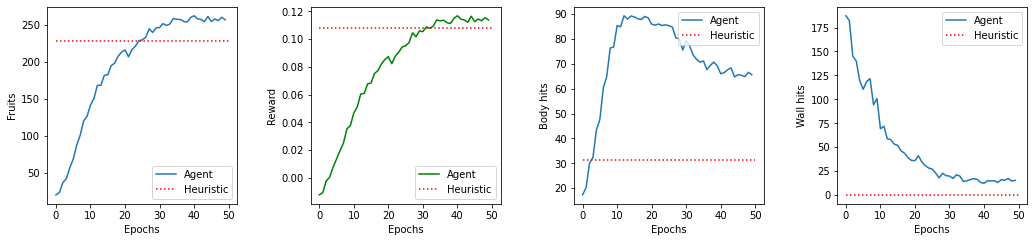

In [16]:
# Training statistics
train_fruits = train_fruits_eaten
train_reward = train_total_rewards
train_wh = train_wall_hits
train_bh = train_body_hits

# Heuristic statistics
heur_fr = heur_fruits
heur_wh = heur_wall_hits
heur_bh = heur_body_hits
heuristic_reward = heur_reward

fig, axs = plt.subplots(1, 4, figsize=(15, 4))

train_fruits = np.sum(np.reshape(train_fruits, (50, 1000)), axis = 1)/100
axs[0].plot(train_fruits, label='Agent')
axs[0].hlines(np.mean(np.sum(np.reshape(heur_fr, (50, 1000)), axis=1)/100), 0, 50, label='Heuristic', color='red', linestyle='dotted')
axs[0].set(ylabel='Fruits')
axs[0].set(xlabel="Epochs")
axs[0].legend(loc='lower right')

train_wh = np.sum(np.reshape(train_wh, (50, 1000)), axis = 1)/100
axs[3].plot(train_wh, label='Agent')
axs[3].hlines(np.mean(np.sum(np.reshape(heur_wall_hits, (50, 1000)), axis=1)/100), 0, 50, colors='red', label='Heuristic', linestyles='dotted')
axs[3].set(ylabel='Wall hits')
axs[3].set(xlabel="Epochs")
axs[3].legend(loc='upper right')

train_bh = np.sum(np.reshape(train_bh, (50, 1000)), axis = 1)/100
axs[2].plot(train_bh, label='Agent')
axs[2].hlines(np.mean(np.sum(np.reshape(heur_body_hits, (50, 1000)), axis=1)/100), 0, 50, colors='red', label='Heuristic', linestyles='dotted')
axs[2].set(ylabel='Body hits')
axs[2].set(xlabel="Epochs")
axs[2].legend(loc='upper right')

train_reward = np.mean(np.reshape(train_reward, (50, 1000)), axis=1)
axs[1].plot(train_reward, label='Agent', color='green')
axs[1].hlines(np.mean(heuristic_reward), 0, 50, colors='red', label='Heuristic', linestyles='dotted')
axs[1].set(ylabel='Reward')
axs[1].set(xlabel="Epochs")
axs[1].legend(loc='lower right')

fig.tight_layout(pad=3.0)

## Evaluation ##

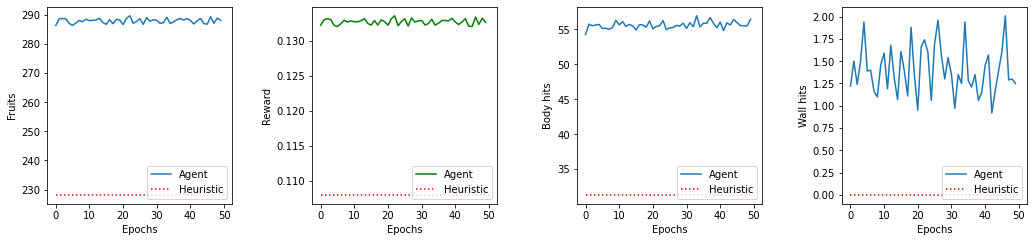

In [17]:
# Evaluation statistics
eval_fruits = eval_fruits_eaten
eval_reward = eval_rewards
eval_wh = eval_wall_hits
eval_bh = eval_body_hits

# Heuristic statistics
heur_fe = heur_fruits
heur_wh = heur_wall_hits
heur_bh = heur_body_hits
heuristic_reward = heur_reward

fig, axs = plt.subplots(1, 4, figsize=(15, 4))

eval_fruits = np.sum(np.reshape(eval_fruits, (50, 1000)), axis = 1)/100
axs[0].plot(eval_fruits, label='Agent')
axs[0].hlines(np.mean(np.sum(np.reshape(heur_fruits, (50, 1000)), axis=1)/100), 0, 50, label='Heuristic', color='red', linestyle='dotted')
axs[0].set(ylabel='Fruits')
axs[0].set(xlabel="Epochs")
axs[0].legend(loc='lower right')

eval_wh = np.sum(np.reshape(eval_wh, (50, 1000)), axis = 1)/100
axs[3].plot(eval_wh, label='Agent')
axs[3].hlines(np.mean(np.sum(np.reshape(heur_wall_hits, (50, 1000)), axis=1)/100), 0, 50, colors='red', label='Heuristic', linestyles='dotted')
axs[3].set(ylabel='Wall hits')
axs[3].set(xlabel="Epochs")
axs[3].legend(loc='lower right')

eval_bh = np.sum(np.reshape(eval_bh, (50, 1000)), axis = 1)/100
axs[2].plot(eval_bh, label='Agent')
axs[2].hlines(np.mean(np.sum(np.reshape(heur_body_hits, (50, 1000)), axis=1)/100), 0, 50, colors='red', label='Heuristic', linestyles='dotted')
axs[2].set(ylabel='Body hits')
axs[2].set(xlabel="Epochs")
axs[2].legend(loc='lower right')

eval_reward = np.mean(np.reshape(eval_reward, (50, 1000)), axis=1)
axs[1].plot(eval_reward, label='Agent', color='green')
axs[1].hlines(np.mean(heuristic_reward), 0, 50, colors='red', label='Heuristic', linestyles='dotted')
axs[1].set(ylabel='Reward')
axs[1].set(xlabel="Epochs")
axs[1].legend(loc='lower right')

fig.tight_layout(pad=3.0)